In [1]:
import networkx as nx

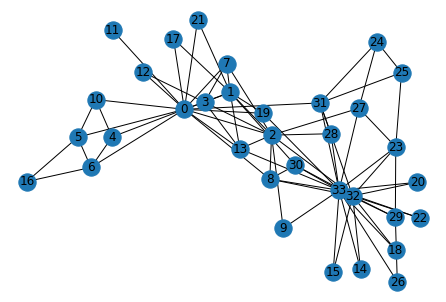

In [2]:
# Create a graph and visualize it
G = nx.karate_club_graph()

import matplotlib.pyplot as plt
nx.draw(G,with_labels=True)

In [3]:
# DG is directed version of G. Replaces each edge {i,j} by (i,j) and (j,i)
DG = nx.DiGraph(G)

# Pick some arbitrary arc costs
c = { (i,j) : i*j for (i,j) in DG.edges }

r = 0  # tree root, arbitrarily chosen

In [4]:
import gurobipy as gp
from gurobipy import GRB

In [5]:
# Create model object
m = gp.Model()

# Create x variables for each edge
x = m.addVars( DG.edges, vtype=GRB.BINARY )

# Objective function: minimize cost of selected edges
m.setObjective( gp.quicksum( c[i,j] * x[i,j] for i,j in DG.edges ), GRB.MINIMIZE )

# Constraints: each node (besides r) should have one incoming arc
m.addConstrs( gp.quicksum( x[j,i] for j in DG.neighbors(i) ) == 1 for i in G.nodes if i != r )
m.addConstr( gp.quicksum( x[j,r] for j in DG.neighbors(r) ) == 0 )

m._DG = DG
m._x = x
m._r = r

m.update()

Academic license - for non-commercial use only - expires 2021-07-26
Using license file C:\Users\Austin\gurobi.lic


In [6]:
# Add (violated) cut constraints in a callback routine
def cut_callback(m, where):
    
    # check if LP relaxation at this BB node is integer
    if where == GRB.Callback.MIPSOL: 
        
        # retrieve the LP relaxation solution at this BB node
        xval = m.cbGetSolution(m._x)
        
        # which edges are selected in the LP solution?
        chosen_edges = [ (i,j) for i,j in m._DG.edges if xval[i,j] > 0.5 ]
        
        # if the solution is not a tree, it will have multiple pieces
        for component in nx.weakly_connected_components( DG.edge_subgraph(chosen_edges) ):
            
            # for each piece that does not contain the tree root r, add a violated constraint
            if m._r not in component:
                
                # must pick at least one edge that points into 'component'
                component_complement = [ i for i in m._DG.nodes if i not in component ]
                boundary_edges = nx.edge_boundary( m._DG, component_complement, component )
                
                m.cbLazy( gp.quicksum( m._x[i,j] for i,j in boundary_edges ) >= 1 )

In [7]:
# Tell Gurobi that we will be adding (lazy) constraints
m.Params.lazyConstraints = 1

# Designate the callback routine to be the function "cut_callback"
m._callback = cut_callback

# Solve the MIP with our callback
m.optimize(m._callback)

Changed value of parameter lazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 34 rows, 156 columns and 156 nonzeros
Model fingerprint: 0x5dfd1638
Variable types: 0 continuous, 156 integer (156 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 13 rows and 28 columns
Presolve time: 0.01s
Presolved: 21 rows, 128 columns, 117 nonzeros
Variable types: 0 continuous, 128 integer (128 binary)

Root relaxation: objective 6.585000e+03, 21 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    6631.0000000 6631.00000  0.00%     -    0s

Cutting planes:
 

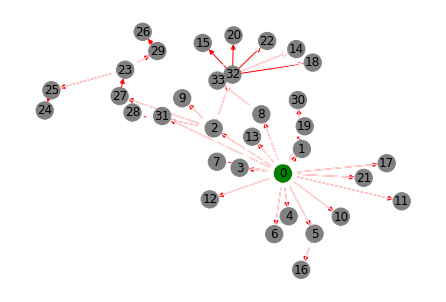

In [8]:
# Visualize the solution
tree_edges = [ (i,j) for i,j in DG.edges if x[i,j].x > 0.5 ]

edge_colors = [ "red" if i in tree_edges else "white" for i in DG.edges ]
node_colors = [ "green" if i == r else "gray" for i in DG.nodes ]

nx.draw( DG, with_labels=True, edge_color=edge_colors, node_color=node_colors )